In [4]:
""""
Figaro times collection times script. 
"""
import numpy as np
import regex as re
import os
import pandas as pd 
from openpyxl import load_workbook, Workbook
from openpyxl.utils.cell import get_column_letter

path_src = "/local/scratch/Figaro/figaro-code"
exp_names = ["mkl"]
exp_paths = {"figaro": "", "mkl": "comparisons/accuracy/python/numpy"}
txt_name = "error.txt"

numeric_const_pattern = r"Relative error is: ([+-]?(\d+(\.\d*)?|\.\d+)([eE][+-]?\d+)?)"
rx = re.compile(numeric_const_pattern)


row_nums = [512, 1024, 2048, 4096]
column_nums = [1, 4, 16, 64, 256, 1024, 4096]
row_col_nums = []

skip_dbs = {"mkl": [], "figaro": []}
join_order = "FullJoin"
#skip_dbs = {"mkl": [12, 15, 16, 18, 19, 20], "figaro": []}

for row_num in row_nums:
    for col_num in column_nums:
        if (row_num > col_num):
            row_col_nums.append((row_num, col_num))

row_col_nums = row_col_nums[:21]



df_measurement_exps = {}

for exp_name in exp_names:
    #Initialize paths for the current experiment 
    exp_path = exp_paths[exp_name]
    accur_path = os.path.join(path_src, exp_path)
    df_measurement = pd.DataFrame(columns=column_nums)
    gather_times_path = os.path.join(accur_path, txt_name)


    for db_idx, db_num in enumerate(range(1, len(row_col_nums))): 
        db_name = "DBCartesianProductAccuracy{}".format(db_num)
        if db_num in skip_dbs[exp_name]:
            continue
        path_txt = os.path.join(accur_path, db_name, join_order, txt_name)
        
        # Writng header files
        row_num = row_col_nums[db_idx][0]
        col_num = row_col_nums[db_idx][1]
        #print("{} {}".format(row_num, col_num))
        match_exists = False
        with open(path_txt, 'r') as file_accur:
            for line in file_accur:
                #print(line)
                match = rx.search(line)
                #print(match)
                if match:
                    match_exists = True
                    relative_error = float(match.group(1))
                    #print(relative_error)
                    df_measurement.at[row_num, col_num] = relative_error
    
        if not match_exists:
            print("ERROR: {} {}".format(row_num, col_num))
    
    df_measurement = df_measurement.astype(float)
    df_measurement_exps[exp_name] = df_measurement

print(df_measurement)


              1             4             16            64            256   \
512   5.693106e-16  1.036814e-15  1.597040e-15  2.128935e-15  1.418542e-14   
1024  3.175110e-16  1.222129e-15  1.263807e-15  1.853365e-15  1.481192e-14   
2048  4.559945e-16  8.368738e-16  1.318314e-15  2.830925e-15  1.775646e-14   
4096  2.632352e-15  4.210788e-15  2.475771e-15  3.678123e-15           NaN   

              1024  4096  
512            NaN   NaN  
1024           NaN   NaN  
2048  1.093138e-13   NaN  
4096           NaN   NaN  


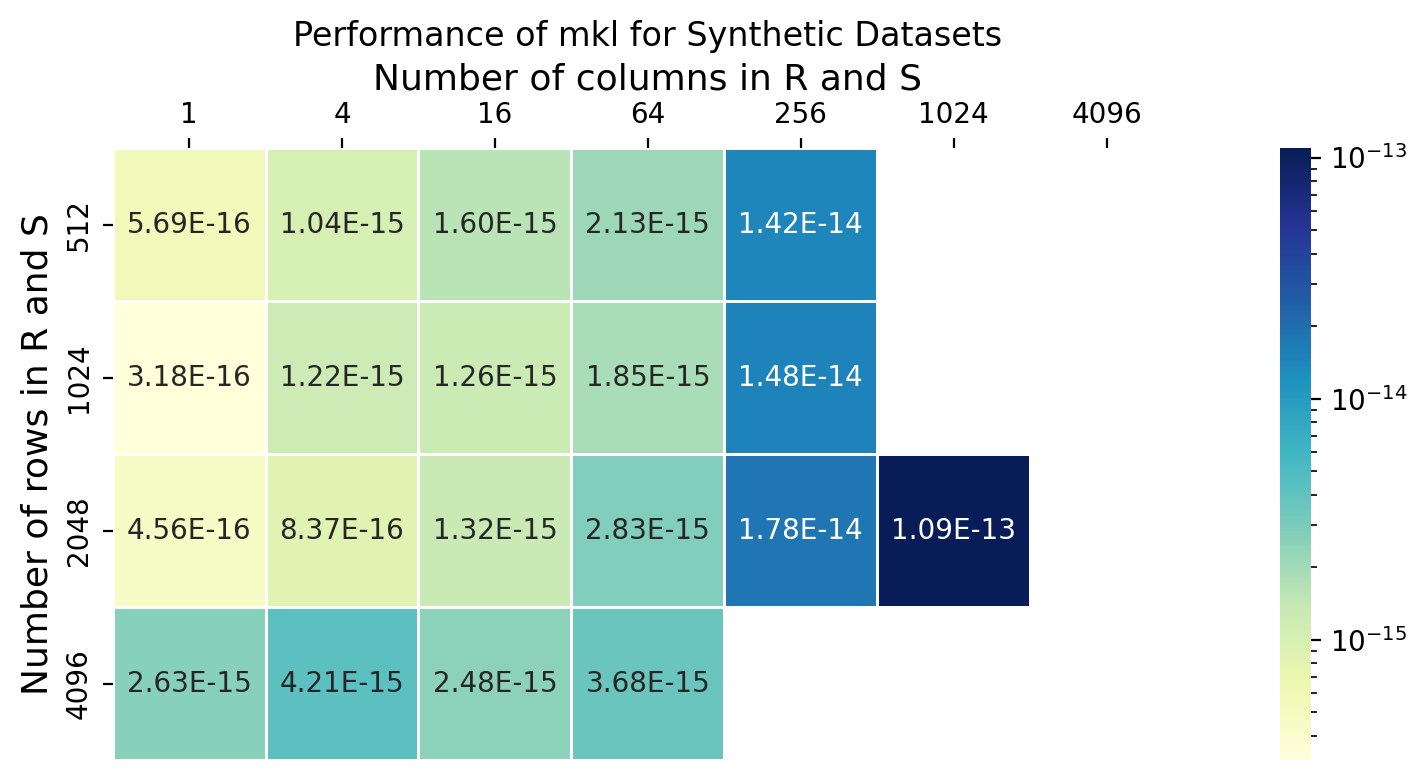

In [5]:
import seaborn as sns
from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt

x_label = "Number of rows in R and S"
y_label = "Number of columns in R and S"

for exp_name in exp_names:
    plt.figure(exp_name, figsize=(10, 4), dpi=200)
    df_measurement = df_measurement_exps[exp_name]
    ax = sns.heatmap(df_measurement, linewidth=0.5, annot=True, fmt='.2E', cmap="YlGnBu", norm=LogNorm(), square=True)

    ax.set_ylabel(x_label, fontsize=13)
    ax.set_xlabel(y_label, fontsize=13)
    ax.set_title("Performance of {} for Synthetic Datasets".format(exp_name), fontsize=12)
    ax.xaxis.set_ticks_position('top') 
    ax.xaxis.set_label_position("top")
    plt.savefig("exp1syn{}.pdf".format(exp_name),bbox_inches='tight')

plt.tight_layout()
plt.show()